# Imports

In [1]:
%pylab inline

plt.rcParams['figure.figsize'] = [10.0, 6.18]
plt.style.use('scandic')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Simulation code

In [2]:
ASSERT_EPS = 1.0e-7

def init_config(N,strategy):
    """Initializes a configurations.
    
    strategy -  one of random/all-up/all-down
    """
    if strategy == "random":
        return 2*random.randint(0,2,N)-1.0
    elif strategy == "all-up":
        return ones((N,),dtype=int)
    elif strategy == "all-down":
        return -1.0*ones((N,),dtype=int)
    else:
        raise ValueError("Unknown strategy in init_config")

class IsingModelMC_1D(object):
    "Implementation of a Metropolis Monte-Carlo simulation of the 1D Ising model"
    
    def __init__(self,pars):
        """
        Constructor - initializes simulation
        
        pars - dictionary that contains parameters of the simulation. The following keys
               are required:
               -) system_size (int > 0)
               -) init_strategy (random/all-up/all-down)
               -) boundary_conditions (free/pbc)
               -) h_over_j (float)
               -) T (float > 0)
        """
        # PARAMETERS
        self.N = int(pars["system_size"])
        if self.N <= 0:
            raise ValueError("system_size must be larger than 0")
        
        if pars["boundary_conditions"] == "pbc":
            self.pbc = True
        elif pars["boundary_conditions"] == "free":
            self.pbc = False
        else:
            raise ValueError("Unknown boundary conditions")
        
        self.h_over_j = pars["h_over_j"]
        self.T = float(pars["T"])        
        if self.T <= 0.0:
            raise ValueError("T must be larger than 0")
        self.beta = 1.0/pars["T"]
        
        # SIMULATION VARIABLES
        self.config = init_config(self.N,pars["init_strategy"])
        
        # STATISTICAL VARIABLES
        self.reset_statistics_variables()
            
    def reset_statistics_variables(self):
        "Refreshes the values of all variables that are cumulatively updated while the simulation runs"
        self.n_attempted = 0
        self.n_accepted = 0
        
        self.t_timeseries = []
        
        self.E = self.get_E()
        self.E_sum = 0.0
        self.E_sum_samples = 0
        self.E_timeseries = []
        
        self.m = self.get_m()
        self.m_sum = 0.0
        self.m_sum_samples = 0.0
        self.m_timeseries = []
        self.m_increment = 2.0/self.N
        
    def __str__(self):
        "Returns a string that contains the current simulation state"
        s = "****************************************************************"
        s += "\n** Ising model MC simulation"
        s += "\n- % 10s = %i"%("N",self.N)
        s += "\n- % 10s = %s"%("PBC","YES" if self.pbc else "NO")
        s += "\n- % 10s = %.2f"%("h_over_j",self.h_over_j)
        s += "\n- % 10s = %.2f"%("E",self.E)
        s += "\n- % 10s = %.2f"%("T",self.T)
        s += "\n- % 10s = %.2f"%("beta",self.beta)
        s += "\n-- STATISTICS --------------------------------------------------"
        s += "\n- % 10s = %.2f"%("E",self.E)
        s += "\n- % 10s = %.2f"%("m",self.m)
        s += "\n- % 10s = %i"%("n_attempted",self.n_attempted)
        s += "\n- % 10s = %i"%("n_accepted",self.n_accepted)
        s += "\n- % 10s = %.2f"%("acc_ratio",float(self.n_accepted)/float(self.n_attempted) if self.n_attempted > 0 else 0.0)
        s += "\n- CONFIG:"
        s += "\n//%s//"%self.config_to_s()
        s += "\n****************************************************************"
        return s
        
    def config_to_s(self):
        "Returns a string that represents the current configuration"
        s = "%s"%('+' if self.config[0] == 1 else '-')
        for i in range(1,self.N):
            s += (" +" if self.config[i] == 1 else " -")
        return s
    
    def reset_cumulative_variables(self):
        "Update all variables that are cumulatively tracked while the simulation is running"
        self.m = self.get_m()
        self.E = self.get_E()

    def print(self):
        "Print the current simulation state"
        print(str(self))
        
    def get_neighbors(self,i):
        "Return the neighbors of spin i"
        if self.pbc:
            neighbors = [(i-1)%self.N, (i+1)%self.N]
        else:
            if i == 0:
                neighbors = [1, ]
            elif i == (self.N - 1):
                neighbors = [N-2, ]
            else:
                neighbors = [i-1, i+1]
        return neighbors

    def get_E_single(self,i):
        """Return the contribution of spin i to the total energy
        
        Pairwise energies are split evenly between the two particles involved"""
        nbs = self.get_neighbors(i)
        sum_E = 0.0
        me = self.config[i]
        for j in nbs:
            sum_E += -0.5*me*self.config[j]
        sum_E += -self.h_over_j*me
        return sum_E
            
    def get_E(self):
        "Return the total current total energy of the system"
        sum_E = 0.0
        for i in range(self.N):
            sum_E += self.get_E_single(i)
        return sum_E
    
    def get_m(self):
        "Return the current magnetization"
        sum_m = 0
        for i in range(self.N):
            sum_m += self.config[i]
        return sum_m/self.N
    
    def get_dE_single(self,i):
        "Return the change in energy of particle i is flipped"
        nbs = self.get_neighbors(i)
        sum_E = 0.0
        me = self.config[i]
        for j in nbs:
            sum_E += 2*me*self.config[j]
        sum_E += 2*self.h_over_j*me
        return sum_E
        
    def do_sweep(self,debug_level=0):
        "Perform one simulation sweep that consists of (number of particles) MC moves"
        for i in range(self.N):
            if debug_level >= 2:
                print("* Doing move % 5i / % 5i"%(i+1,self.N))
            self.do_move(debug_level=debug_level)
            
    def acceptance(self,dE,debug_level=0):
        "Return true if Metropolis MC acceptance criterion is accepted - false otherwise"
        if dE < 0:
            if debug_level >= 3:
                print("* Acceptance test: dE < 0 -> ACCEPTED",end='')
            return True
        else:
            p = exp(-self.beta*dE)
            _random = random.random()
            if debug_level >= 3:
                print("* Acceptance test: p = % 5.3f, random number = % 5.3f ->"%(p,_random),end='')
            if _random < p:
                if debug_level >= 3:
                    print("ACCEPTED")
                return True
            else:
                if debug_level >= 3:
                    print("REJECTED")
                return False
            
    def accept_move(self,i,dE,debug_level=0):
        """Accept a flip of spin i
        
        If debug_level >= 3 or higher a consistency check of the cumulative variables E
        and m is performed. If debug_level >= 4 the state of the system before the move 
        is accepted is printed.
        """
        if debug_level >= 4:
            self.print()
        self.n_accepted += 1
        self.m -= self.m_increment*self.config[i]
        self.config[i] *= -1
        self.E += dE
        if debug_level >= 3:
            assert fabs(self.m - self.get_m()) < ASSERT_EPS, "inconsistent magnetization: running m = %.8f != %.8f = summed m"%(self.m,self.get_m())
            assert fabs(self.E - self.get_E()) < ASSERT_EPS, "inconsistent energy: running E = %.8f != %.8f = summed E"%(self.E,self.get_E())
            
    def do_move(self,debug_level=0):
        "Perform a single Metropolis MC move including an acceptance test"
        i = random.randint(self.N)
        
        if debug_level >= 2:
            print("* Chose spin %i"%i)
            
        dE = self.get_dE_single(i)
        if debug_level >= 2:
            print("* me = %i"%self.config[i],end="")
            for j,_nb in enumerate(self.get_neighbors(i)):
                print(", NB %i = %i"%(j,self.config[_nb]),end="")
            print("")
            print("* dE = %.2f"%dE)
            
        self.n_attempted += 1
        if self.acceptance(dE,debug_level=debug_level):
            self.accept_move(i,dE,debug_level=debug_level)
        else:
            pass
        
    def do_stats(self,i,debug_level=0):
        "Update the statistics based on the current state of the system"
        self.t_timeseries.append(i)
        
        self.E_sum += self.E
        self.E_sum_samples += 1
        self.E_timeseries.append(self.E)
        
        self.m_sum += self.m
        self.m_sum_samples += 1
        self.m_timeseries.append(self.m)
        
    def print_stats_header(self):
        "Print a header line for the statistics output"
        s = "% 10s"%"t"
        s += " | % 10s"%"MAGN"
        s += " | % 10s"%"AVG MAGN"
        s += " | % 10s"%"ENERGY"
        s += " | % 10s"%"AVG ENERGY"
        s += " | % 10s"%"ACC RATIO"
        print(s)
        
    def print_stats(self,i):
        "Print the statistics output"
        s = "% 10s"%("% 8i"%i) # timestep
        
        s += " | % 10s"%("% 8.2f"%self.m)
        avg_m = self.m_sum / self.m_sum_samples if self.m_sum_samples > 0 else 0.0
        s += " | % 10s"%("% 8.2f"%avg_m)
        
        s += " | % 10s"%("% 8.2f"%self.E)
        avg_E = self.E_sum / self.E_sum_samples if self.E_sum_samples > 0 else 0.0
        s += " | % 10s"%("% 8.2f"%avg_E)
        
        acc_ratio = float(self.n_accepted)/float(self.n_attempted) if self.n_attempted > 0 else 0.0
        s += " | % 10s"%("% 8.2f"%acc_ratio)
        print(s)
        
    def run(self,n_sweeps,pars,debug_level=0):
        """Run a simulation
        
        n_sweeps - int: Number of sweeps to be performed
        pars - dict: parameters used for the simulation. Must include keys i_stats and i_stats_out
        debug_level - int: 0 or larger, controls level of debug output
        
        """
        i_stats = int(pars["i_stats"])
        i_stats_out = int(pars["i_stats_out"]) if i_stats > 0 else 0
        if i_stats_out > 0: 
            self.print_stats_header()
        for i in range(n_sweeps):
            self.do_move(debug_level=debug_level)
            if i_stats > 0 and (i % i_stats == 0):
                self.do_stats(i)
            if i_stats_out > 0 and (i % i_stats_out == 0):
                self.print_stats(i)
            if i % 10000 == 0:
                self.reset_cumulative_variables()
                
    def get_timeseries(self):
        """Return timeseries tracked while the last simulation was run
        
        Returns a dictionary with the name of variable as key and numpy.ndarray as values
        """
        return dict(
            t = array(self.t_timeseries),
            m = array(self.m_timeseries),
            E = array(self.E_timeseries)
        )
    
    def get_averages(self):
        return dict(
            m = self.m_sum / self.m_sum_samples if self.m_sum_samples > 0 else 0.0,
            E = self.E_sum / self.E_sum_samples if self.E_sum_samples > 0 else 0.0
        )

# Initialization

In [3]:
pars = dict(
    system_size = 100,
    h_over_j = 0.0,
    init_strategy = "random",
    boundary_conditions = "pbc",
    T=1.0,
    i_stats = 1,
    i_stats_out = 100
)

# Run

In [4]:
system = IsingModelMC_1D(pars)
system.print()

system.run(1000,pars,debug_level=0)

system.print()

****************************************************************
** Ising model MC simulation
-          N = 100
-        PBC = YES
-   h_over_j = 0.00
-          E = -4.00
-          T = 1.00
-       beta = 1.00
-- STATISTICS --------------------------------------------------
-          E = -4.00
-          m = -0.14
- n_attempted = 0
- n_accepted = 0
-  acc_ratio = 0.00
- CONFIG:
//+ - - - - + + - - - + - - - - + - - + + + - + - - + - - - + + - - - + + - - - - - - + + - - - - - + + + + - - - + - + + + + + - + - + - + + - + - - + + + - + + - + - + - - - - - - - + + - - + - + - +//
****************************************************************
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |      -0.12 |      -0.12 |      -4.00 |      -4.00 |       1.00
       100 |      -0.20 |      -0.14 |     -40.00 |     -28.08 |       0.56
       200 |       0.16 |      -0.08 |     -56.00 |     -38.51 |       0.54
       300 |       0.30 |       0.02 |    

Text(0, 1, 'Histogram')

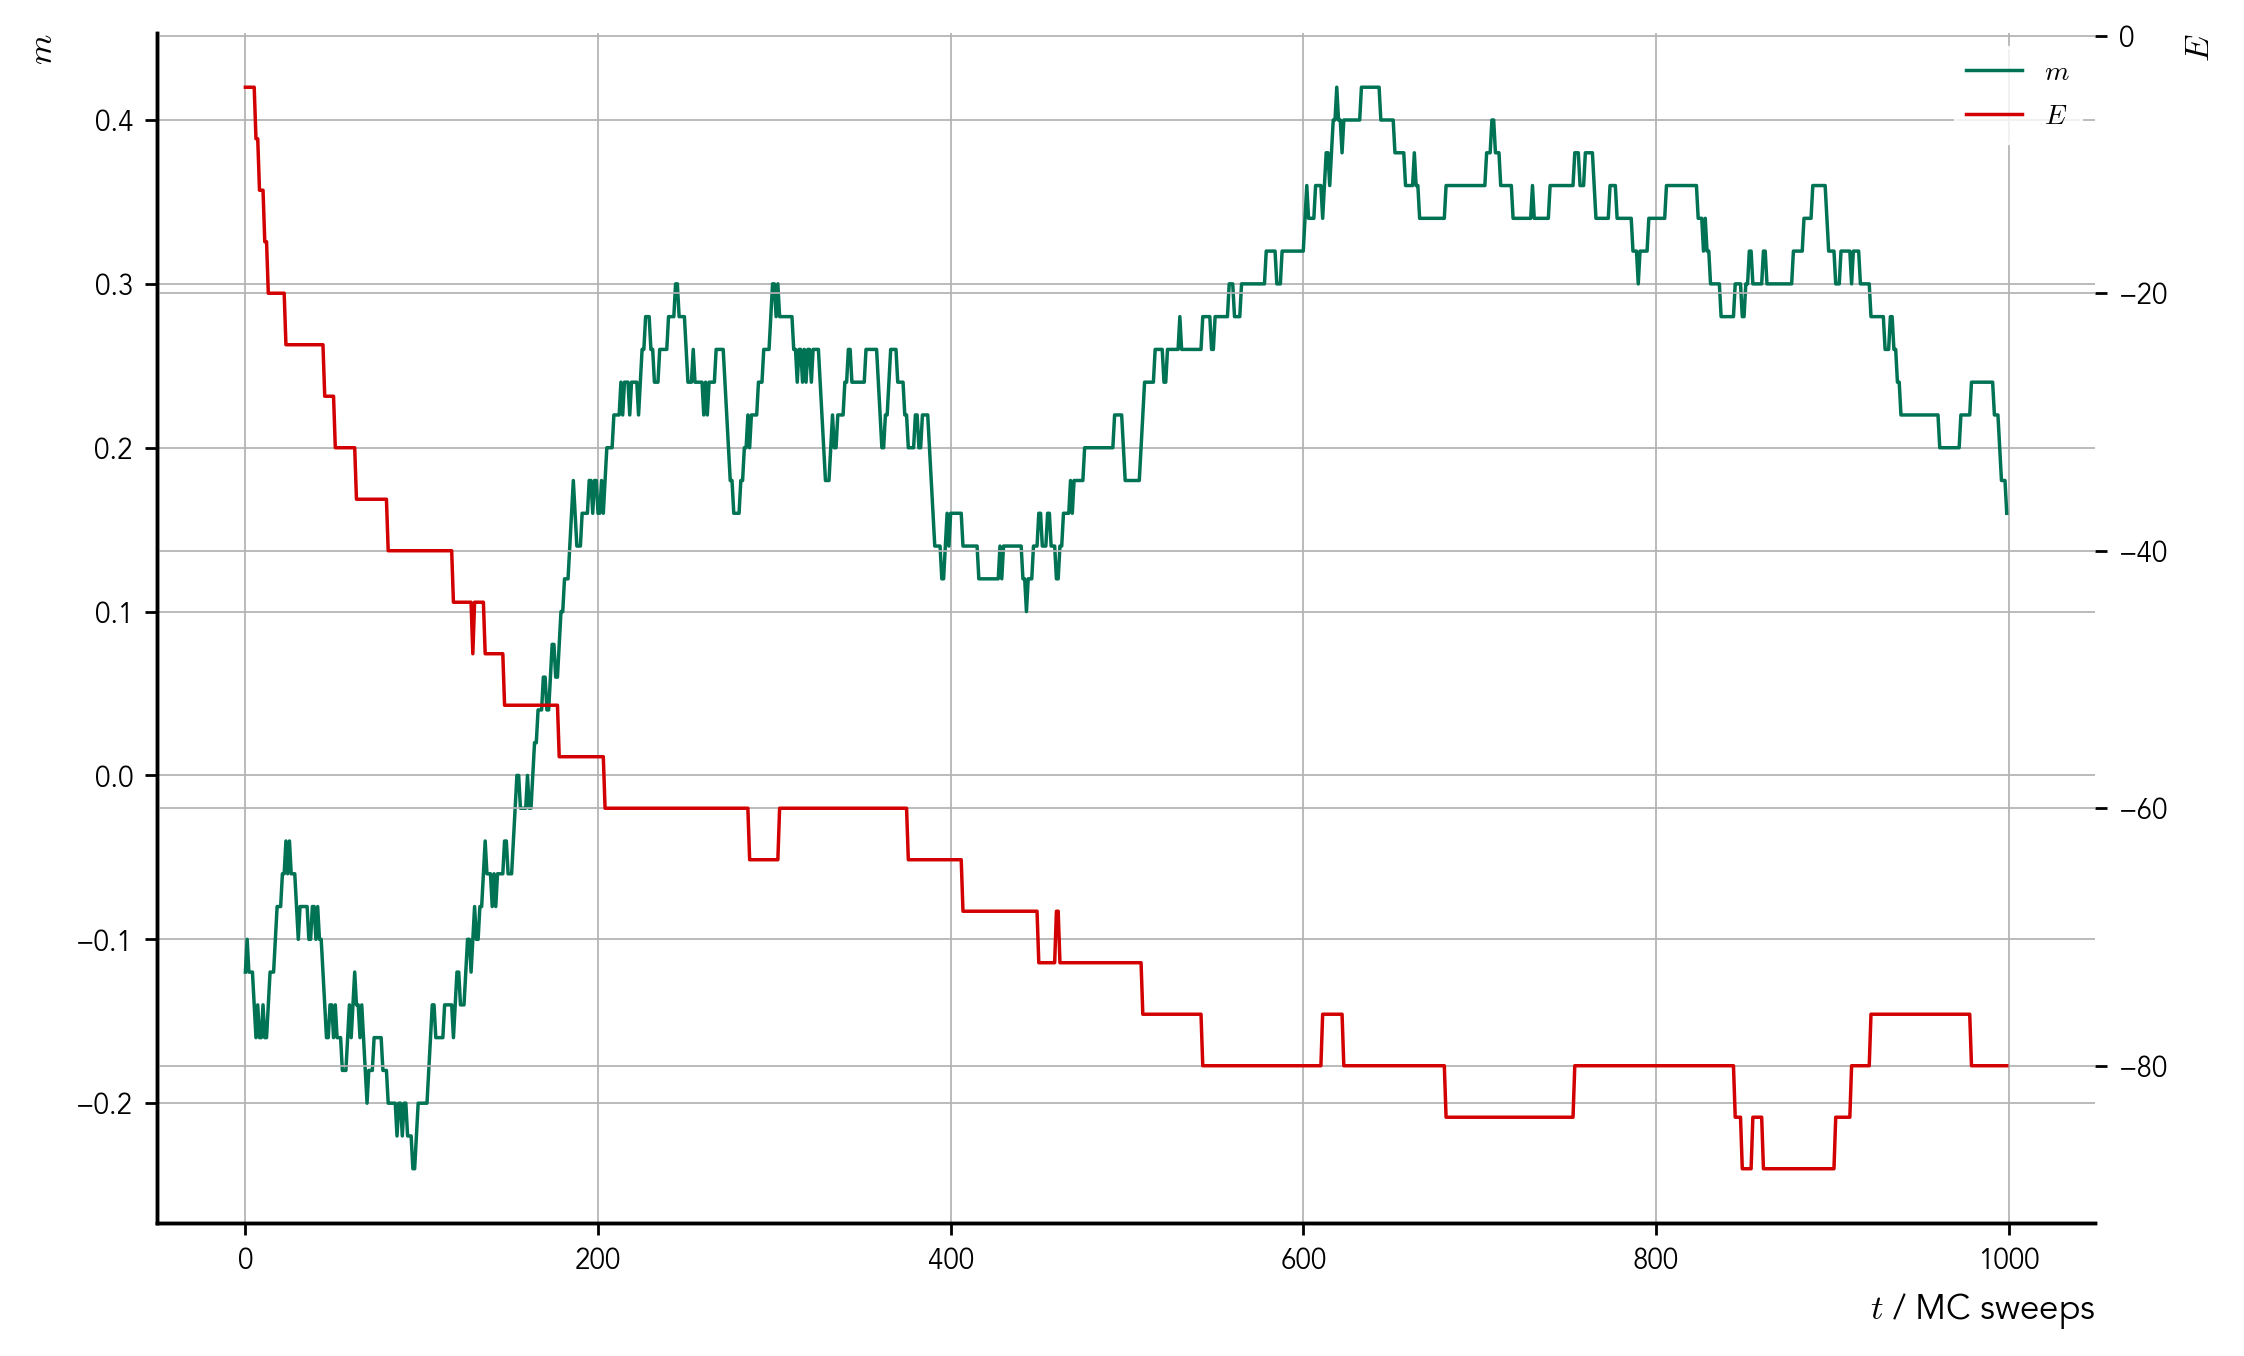

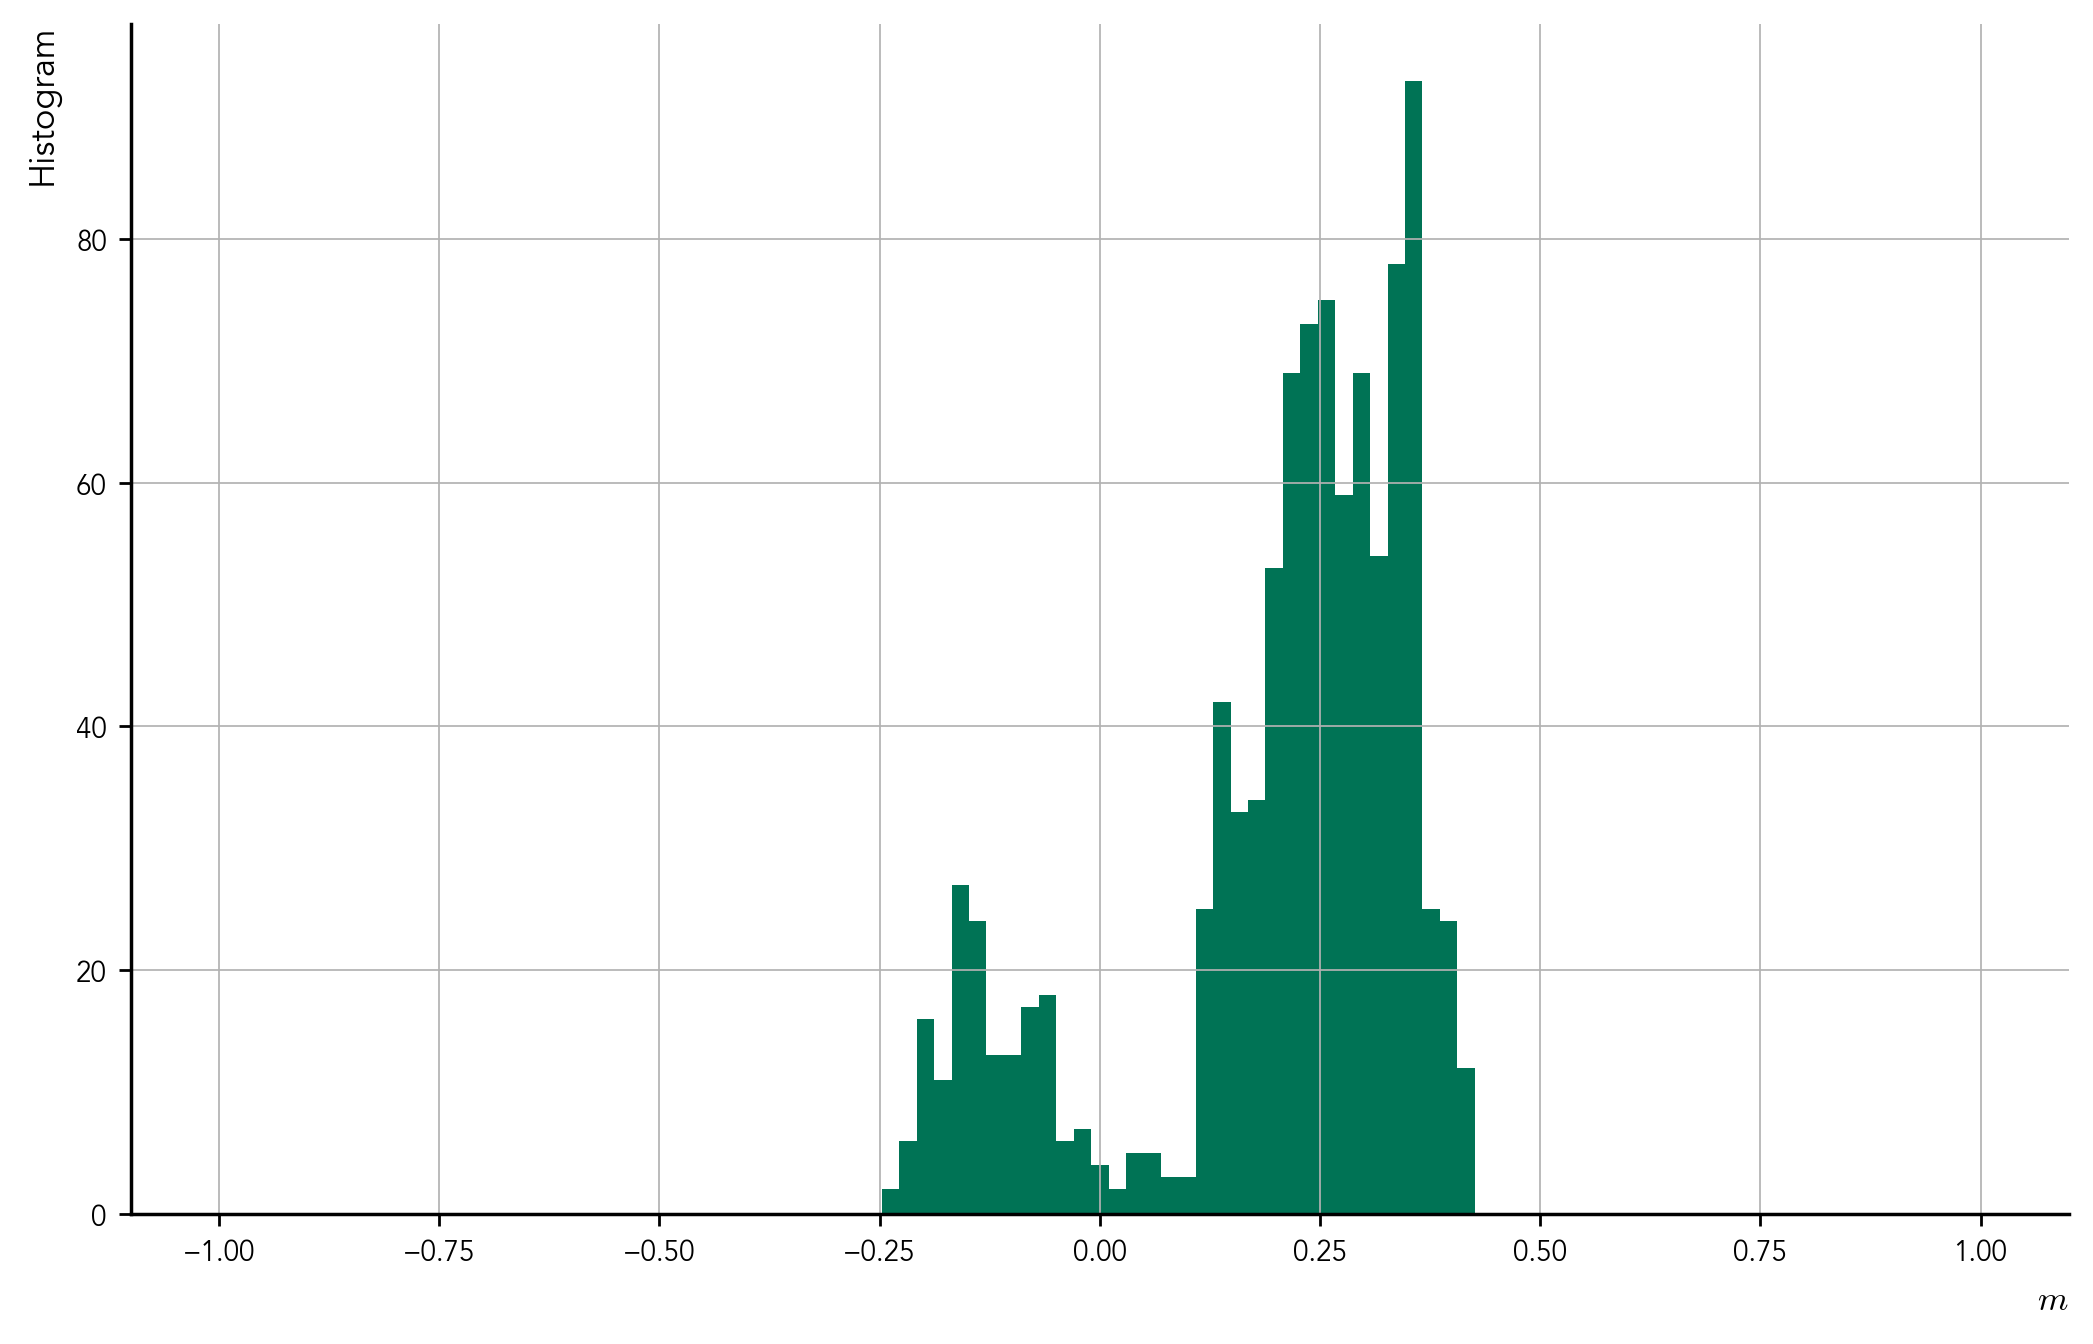

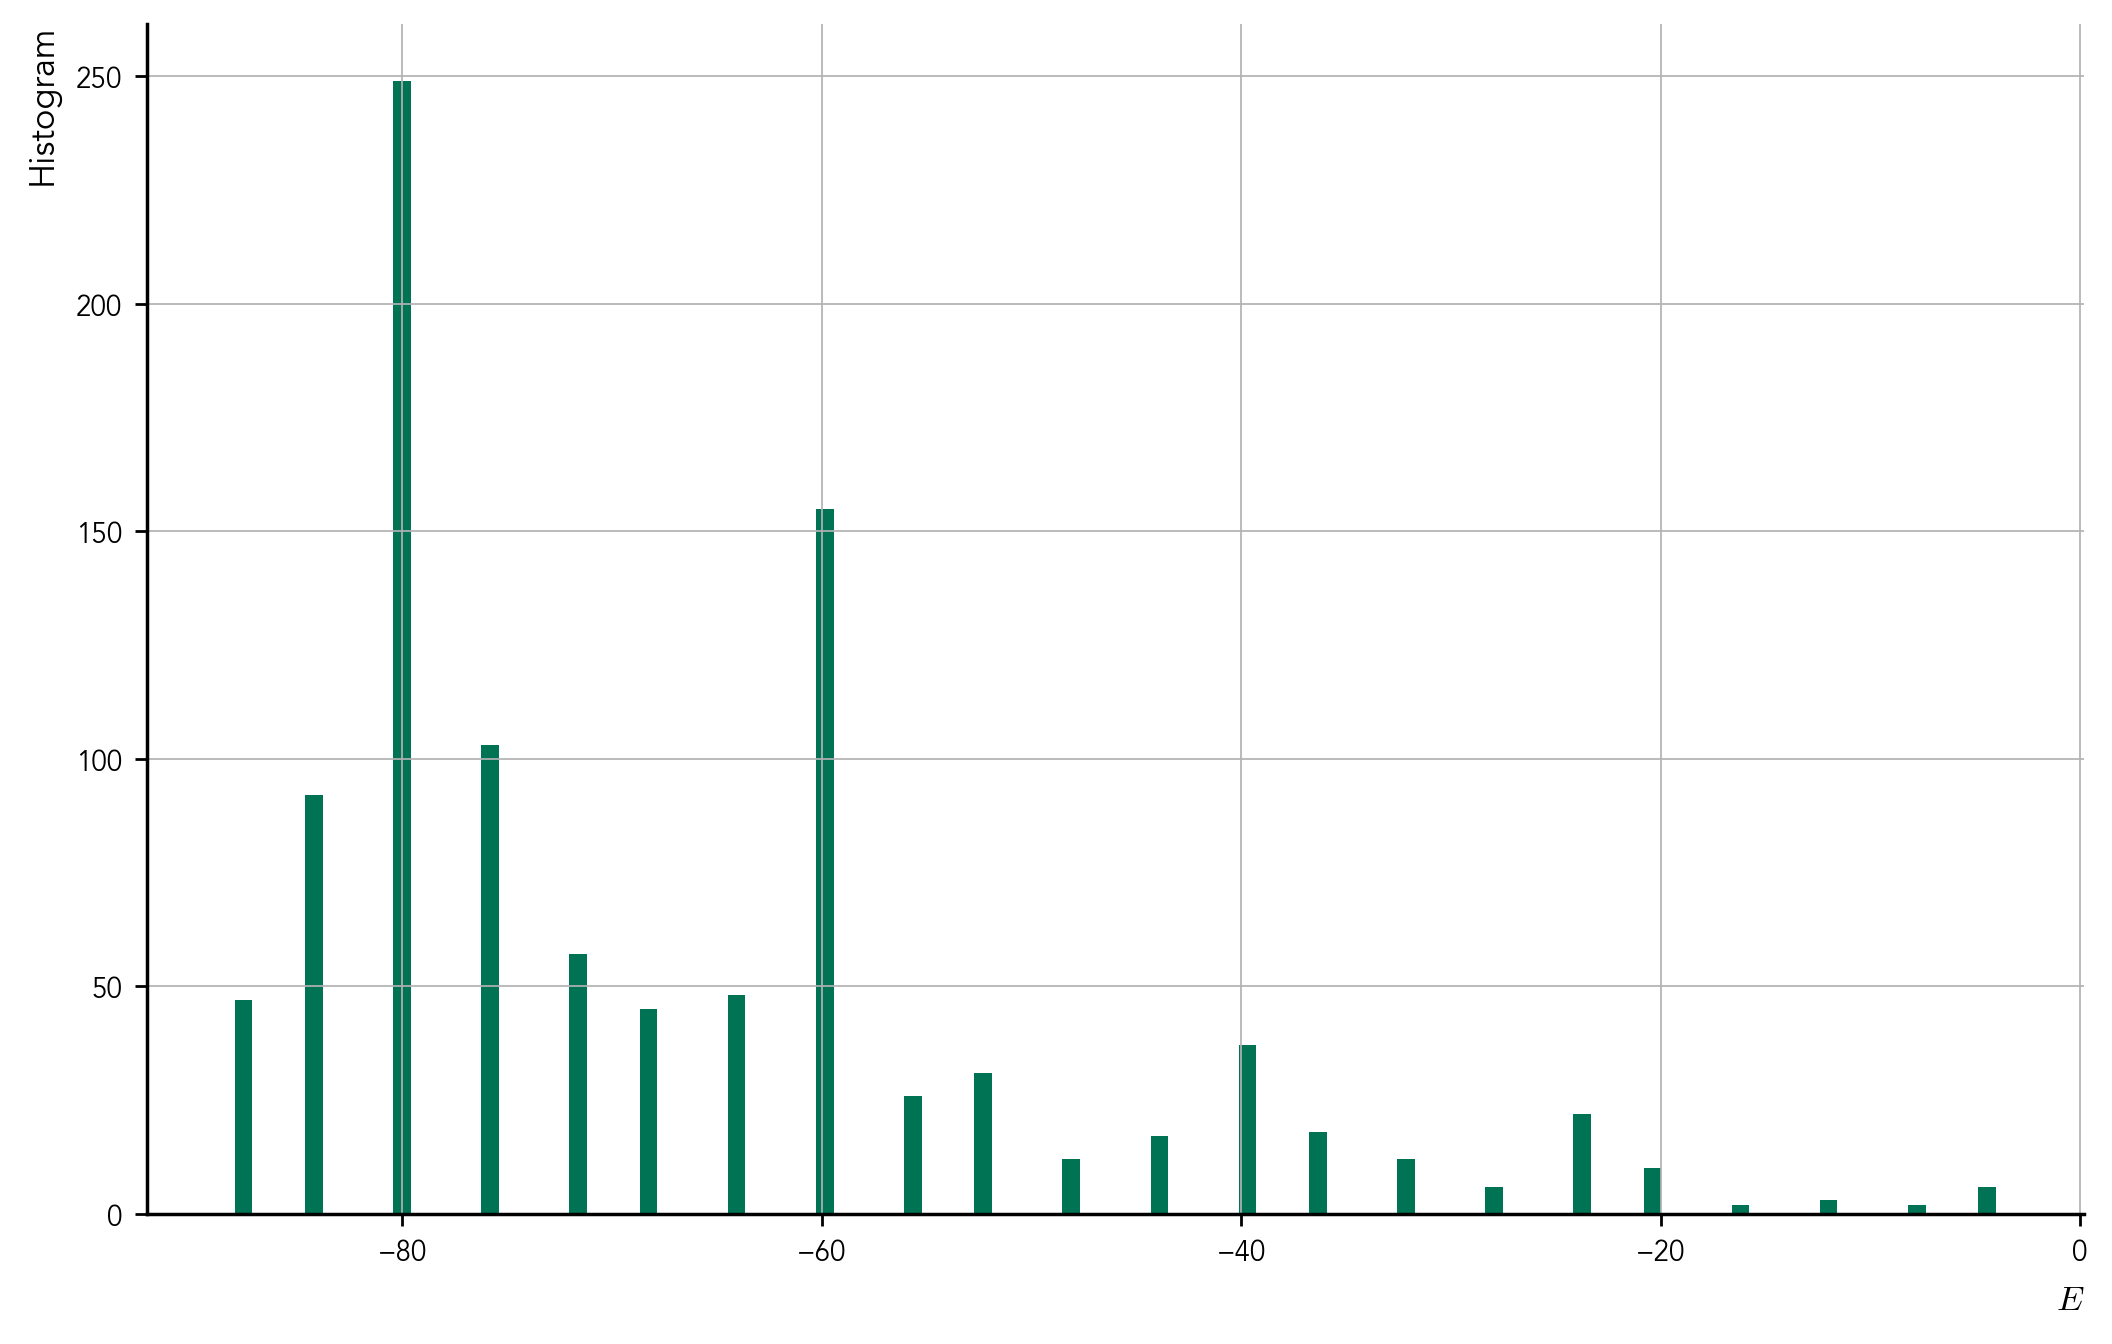

In [5]:
figure()
timeseries = system.get_timeseries()
p_m, = plot(timeseries['t'],timeseries['m'],label='m',color='C0')
xlabel(r'$t$ / MC sweeps')
ylabel(r'$m$')

twinx()

p_e, = plot(timeseries['t'],timeseries['E'],label='E',color='C1')
xlabel(r'$t$ / MC sweeps')
ylabel(r'$E$')

legend([p_m,p_e],[r'$m$',r'$E$']);

figure()
hist(timeseries['m'],bins=int(2*pars['system_size']/2+1),range=[-1.0,1.0]);
xlabel(r'$m$')
ylabel(r'Histogram')

figure()
hist(timeseries['E'],bins=100);
xlabel(r'$E$')
ylabel(r'Histogram')

# Example 9: magnetization (as a function of external field & system size)

In [6]:
def get_pars(h,size):
    return dict(
        system_size = size,
        h_over_j = h,
        init_strategy = "random",
        boundary_conditions = "pbc",
        T=1.0,
        i_stats = 10,
        i_stats_out = 0
    )

hs = np.linspace(0.0, 1.4, 15)

# this will take a few minutes on your average machine
def get_m_of_h(size):
    ms = []
    m_timeseries = []
    for h in hs:
        print("** Running simulation at H = %g"%h)
        _pars = get_pars(h,size)
    
        system = IsingModelMC_1D(_pars)
        
        system.run(10000 // size, _pars)
        system.reset_statistics_variables()
        system.run(80000 // size, _pars)
    
        _avgs = system.get_averages()
        ms.append(_avgs['m'])
        m_timeseries.append(system.get_timeseries()['m'])
    return ms,m_timeseries
    
sizes = [2, 5, 10, 50, 100]
ms_of_h = []
m_timeseries_of_h = []
for size in sizes:
    print("----- SIZE % 4i -----"%size)
    avg_m, m_timeseries = get_m_of_h(size)
    ms_of_h.append(avg_m)
    m_timeseries_of_h.append(m_timeseries)
    

----- SIZE    2 -----
** Running simulation at H = 0
** Running simulation at H = 0.1
** Running simulation at H = 0.2
** Running simulation at H = 0.3
** Running simulation at H = 0.4
** Running simulation at H = 0.5
** Running simulation at H = 0.6
** Running simulation at H = 0.7
** Running simulation at H = 0.8
** Running simulation at H = 0.9
** Running simulation at H = 1
** Running simulation at H = 1.1
** Running simulation at H = 1.2
** Running simulation at H = 1.3
** Running simulation at H = 1.4
----- SIZE    5 -----
** Running simulation at H = 0
** Running simulation at H = 0.1
** Running simulation at H = 0.2
** Running simulation at H = 0.3
** Running simulation at H = 0.4
** Running simulation at H = 0.5
** Running simulation at H = 0.6
** Running simulation at H = 0.7
** Running simulation at H = 0.8
** Running simulation at H = 0.9
** Running simulation at H = 1
** Running simulation at H = 1.1
** Running simulation at H = 1.2
** Running simulation at H = 1.3
** Runn

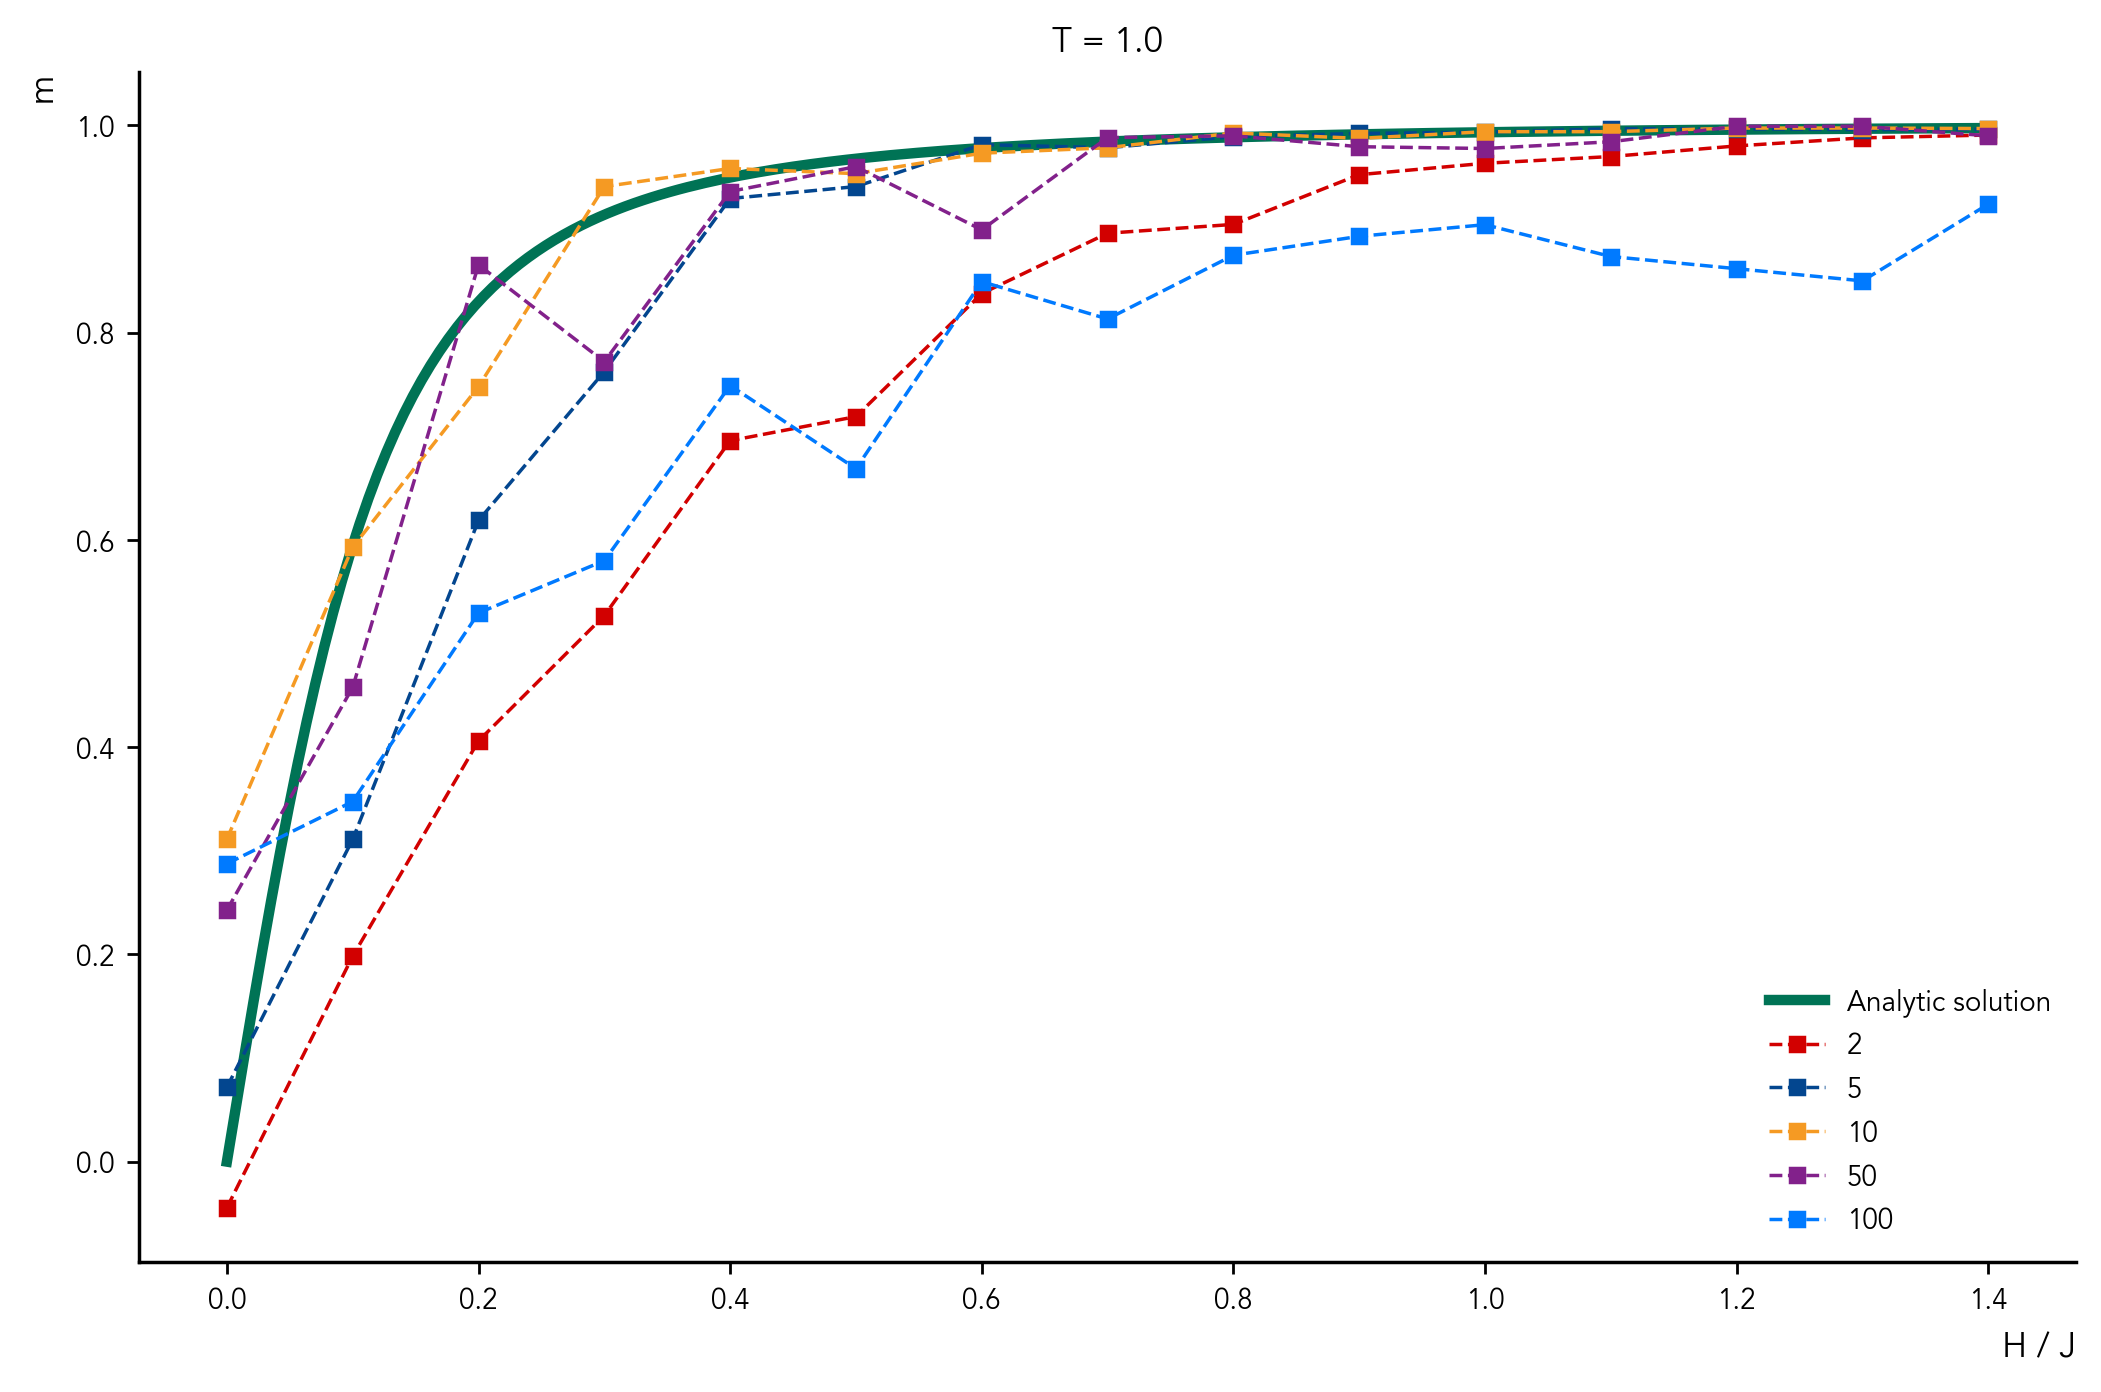

In [7]:
def m(h_over_J,J,T):
    h = array(h_over_J)*J
    beta = 1.0/T
    return exp(beta*J)*sinh(beta*h)/sqrt(exp(2*beta*J)*sinh(beta*h)**2 + exp(-2*beta*J))

h_plot = np.linspace(0.0, 1.4, 200)
plot(h_plot, m(h_plot,1.0,1.0),lw=3.0,alpha=1.0,label='Analytic solution')

for size,m_of_h in zip(sizes,ms_of_h):
    plot(array(hs),m_of_h,marker='s',ls='--',label=str(size))

legend()
grid()
xlabel(r'H / J')
ylabel(r'm')
title("T = 1.0");

# Exercise 10a:

In [8]:
def autocorrelation_function(m_ts, k_max, system):
    
    N_points = m_ts.size
    
    C_k = np.zeros(k_max)
    
    for k in range(0, k_max):
        m_t_k = m_ts[:N_points-k] * m_ts[k:]
        C_k[k] = np.sum(m_t_k) / (N_points-k)
     
    m_squared = np.mean(m_ts*m_ts)
    m_avg = np.mean(m_ts)
    variance = m_squared - m_avg**2
    C_k = (C_k - m_squared**2) / variance
    
    return C_k, m_avg, variance

In [9]:
pars = dict(
    system_size = 100,
    h_over_j = 0.0,
    init_strategy = "random",
    boundary_conditions = "pbc",
    T=1.0,
    i_stats = 10,
    i_stats_out = 10000
)


system = IsingModelMC_1D(pars)
system.run(500000, pars, debug_level=0)

         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       0.00 |       0.00 |       0.00 |       0.00 |       0.00
     10000 |       0.28 |       0.05 |     -80.00 |     -73.60 |       0.27
     20000 |      -0.20 |       0.02 |     -72.00 |     -75.11 |       0.25
     30000 |      -0.28 |       0.01 |     -72.00 |     -75.53 |       0.24
     40000 |      -0.26 |      -0.00 |     -76.00 |     -75.04 |       0.25
     50000 |      -0.22 |      -0.04 |     -76.00 |     -75.44 |       0.24
     60000 |       0.04 |      -0.02 |     -80.00 |     -75.59 |       0.24
     70000 |       0.16 |      -0.01 |     -72.00 |     -75.75 |       0.24
     80000 |       0.68 |       0.03 |     -84.00 |     -75.80 |       0.24
     90000 |      -0.02 |       0.04 |     -84.00 |     -75.70 |       0.24
    100000 |       0.36 |       0.05 |     -80.00 |     -75.76 |       0.24
    110000 |      -0.26 |       0.05 |     -84.00 |     -75.85 |       0.24
    120000 |

In [10]:
timeseries = system.get_timeseries()
k_max = 2500
equ_frames = 25000
N_frames = len(timeseries["m"])
C_k, m_avg, variance = autocorrelation_function(timeseries["m"][N_frames-equ_frames:], k_max, system)
k = np.linspace(0, k_max-1, k_max, dtype=int)

Text(0, 1, 'C(k)')

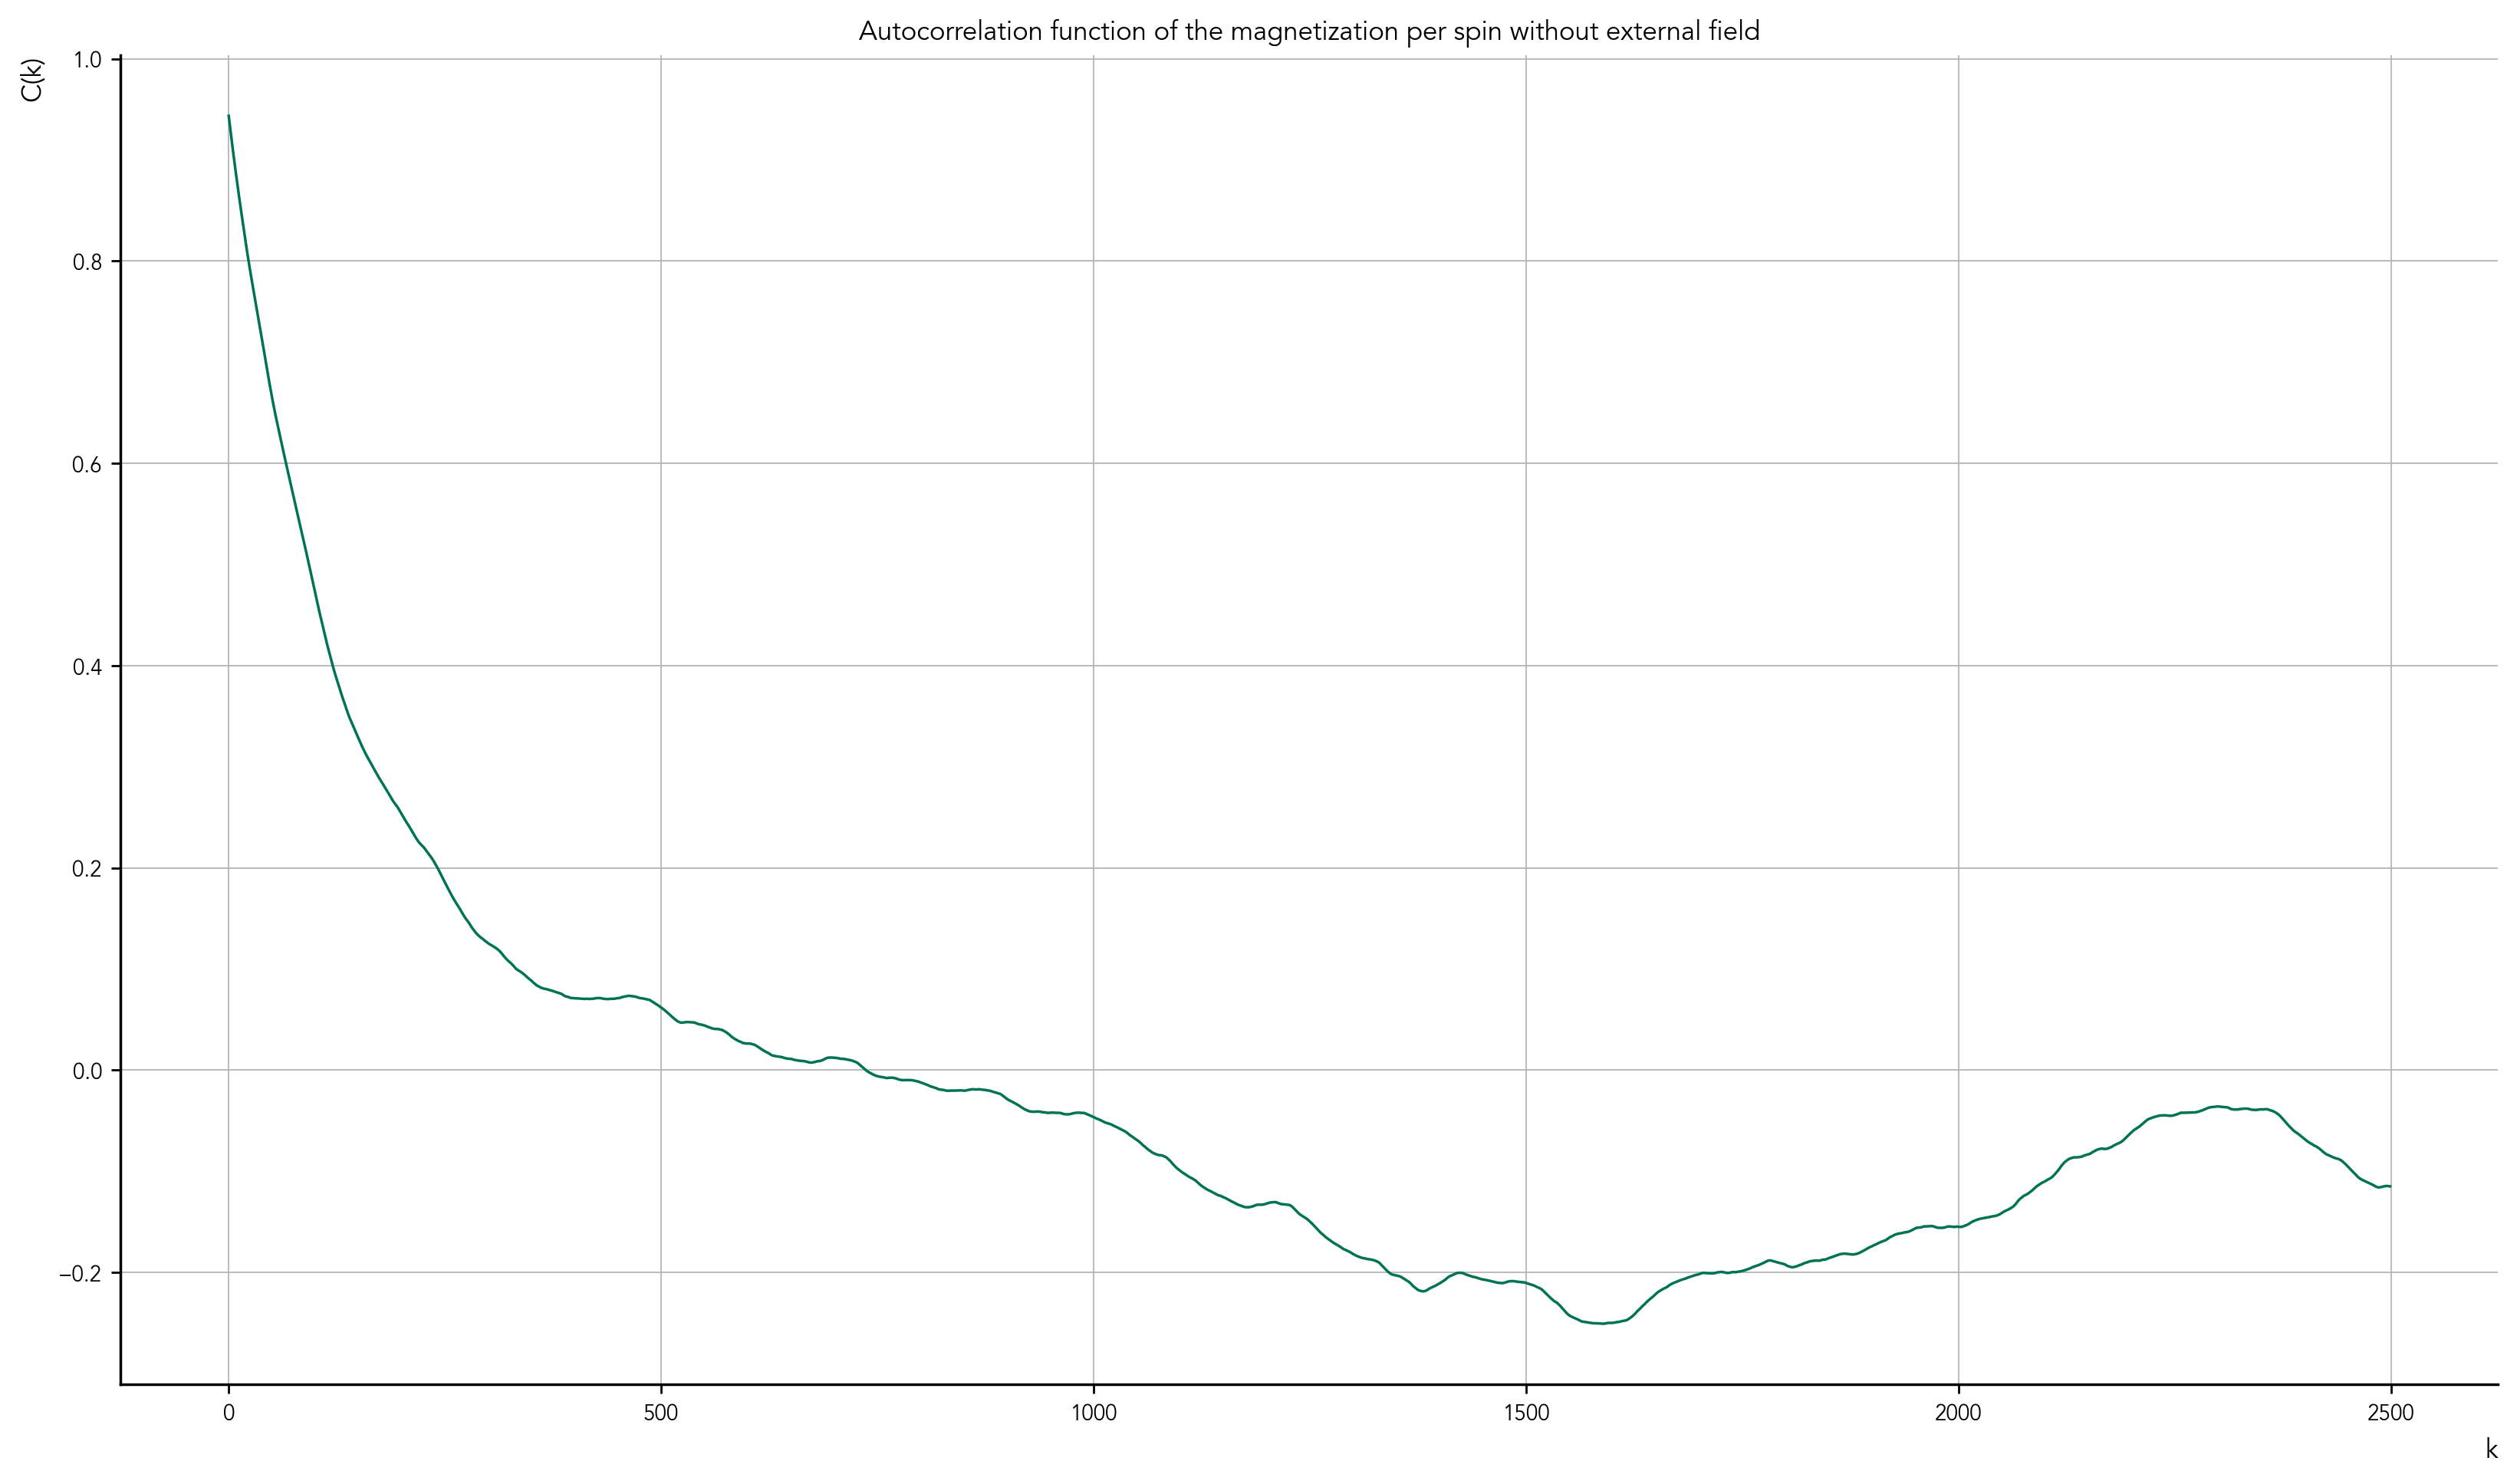

In [11]:
fig,ax= plt.subplots(figsize=(16, 9))

ax.plot(k, C_k)
ax.set_yscale('linear')
ax.set_title('Autocorrelation function of the magnetization per spin without external field')
ax.set_xlabel('k')
ax.set_ylabel('C(k)')

In [13]:

zero_crossing = 0
for i, c in enumerate(C_k):
    if c < 0:
        zero_crossing = i
        break 
        
variance_eff = variance/M *np.sum(C_k[:zero_crossing])

print("Effective variance: {}".format(variance_eff))
print("The magnetization per spin is {:f} +/- {:f}".format(m_avg, sqrt(variance_eff)))

NameError: name 'M' is not defined

# Exercise 10b:

In [ ]:
def analytic_spin_corr(l_array, beta, h_over_j_array):
    
    sqrt_term = np.sqrt(np.exp(2*beta)*np.sinh(beta*h_over_j_array)**2 + np.exp(-2*beta))
    
    lambda_m = np.exp(beta)*np.cosh(beta*h_over_j_array) - sqrt_term
    
    lambda_p = np.exp(beta)*np.cosh(beta*h_over_j_array) + sqrt_term
    
    
    lambda_ratio_power = np.power(np.transpose(np.tile(lambda_m/lambda_p, (l_array.size,1))), np.tile(l_array,(4,1)))
                    
    sp_corr_ana = np.transpose(np.tile(np.cos(two_phi(beta,h_over_j_array))**2,(l_array.size,1))) \
                    + np.transpose(np.tile(np.sin(two_phi(beta,h_over_j_array))**2,(l_array.size,1))) \
                    *lambda_ratio_power
    
    return sp_corr_ana
    
def two_phi(beta, h_over_j_array):
    return np.arctan(1/(np.exp(2*beta)*np.sinh(beta*h_over_j_array)))

In [ ]:

pars3 = dict(
    system_size = 1000,
    h_over_j = 0.0,
    init_strategy = "random",
    boundary_conditions = "pbc",
    T=1.0,
    i_stats = 10,
    i_stats_out = 100000
)


H_runs = 4
l_max = 30
avg_size = 1000
H_array = np.linspace(0,1, H_runs)
H_array[0] = 0.01
sp_corr = np.zeros([H_runs, l_max])

for i in range(0,H_runs):
    pars3["h_over_j"] = H_array[i]
    
    system3 = IsingModelMC_1D(pars3)
    system3.run(500000,pars3,debug_level=0)
    
    for l in range(0, l_max):
        sp_corr[i,l] = np.mean(system3.config[:avg_size] * np.roll(system3.config,-l)[:avg_size])
    

         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       0.01 |       0.01 |      -4.10 |      -4.10 |       1.00
    100000 |      -0.14 |       0.03 |    -790.56 |    -750.77 |       0.25
    200000 |       0.05 |       0.02 |    -772.52 |    -753.34 |       0.24
    300000 |       0.01 |       0.01 |    -760.06 |    -756.72 |       0.24
    400000 |       0.06 |       0.01 |    -736.56 |    -759.22 |       0.24
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       0.02 |       0.02 |      30.00 |      30.00 |       0.00
    100000 |       0.95 |       0.89 |   -1282.00 |   -1201.68 |       0.07
    200000 |       0.90 |       0.91 |   -1215.33 |   -1219.15 |       0.06
    300000 |       0.95 |       0.91 |   -1260.67 |   -1225.45 |       0.06
    400000 |       0.94 |       0.91 |   -1250.00 |   -1223.64 |       0.06
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |

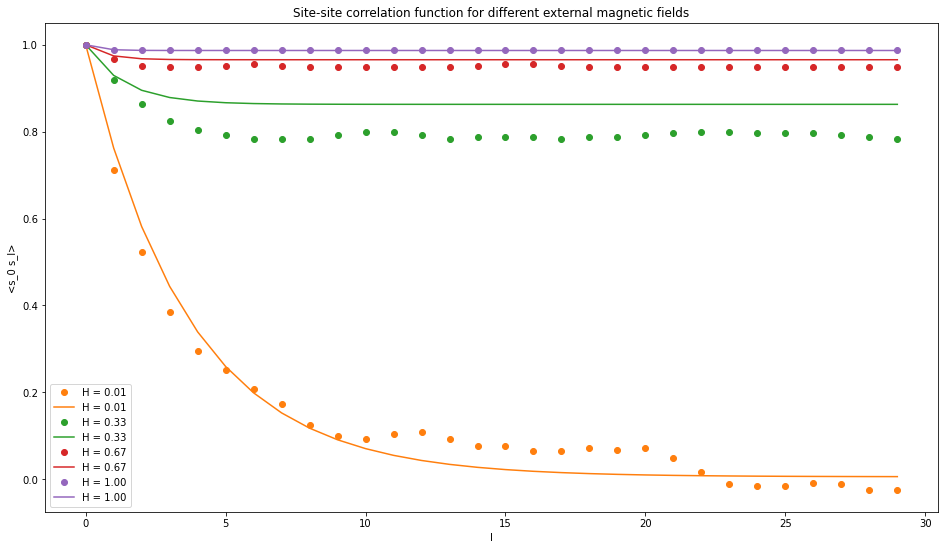

In [ ]:

l = np.linspace(0, l_max-1, l_max, dtype=int)

fig2,ax2= plt.subplots(figsize=(16, 9))
spin_corr_ana = analytic_spin_corr(l, system3.beta, H_array)

for i in range(0, H_runs):
    color = next(ax._get_lines.prop_cycler)['color']
    ax2.plot(l, sp_corr[i,:],'o', label="H = {:0.2f}".format(H_array[i]), color=color)
    ax2.plot(l, spin_corr_ana[i,:], label="H = {:0.2f}".format(H_array[i]), color=color)
    
ax2.set_yscale('linear')
ax2.set_title('Site-site correlation function for different external magnetic fields')
ax2.set_xlabel('l')
ax2.set_ylabel('<s_0 s_l>')
ax2.legend()